In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns

In [2]:
from tqdm import tqdm

# Global variables

In [3]:
data_dir = '/home/a_vikhorev/Projects/tmp/DRRF/2024/Data'
trio_dir = '/home/a_vikhorev/Projects/tmp/DRRF/2024/workspace/HaplotypeTools_workspace'

# Import Datasets

In [5]:
ashk_fath = pd.read_csv(trio_dir+'/Ashkenazi_Son-Father.diff.sites_in_files', sep='\t', comment='#')
ashk_moth = pd.read_csv(trio_dir+'/Ashkenazi_Son-Mother.diff.sites_in_files', sep='\t', comment='#')

In [6]:
chin_fath = pd.read_csv(trio_dir+'/Chinese_Son-Father.diff.sites_in_files', sep='\t', comment='#')
chin_moth = pd.read_csv(trio_dir+'/Chinese_Son-Mother.diff.sites_in_files', sep='\t', comment='#')

# Trio analysis

In [14]:
def get_denovo_mutations(fath_df, moth_df):
    
    fath_df.rename(columns={'IN_FILE':'Father'}, inplace=True)
    pos_list = [row.CHROM + ':' + row.POS1 if row.POS1 != '.' else row.CHROM + ':' + row.POS2 for row in fath_df.itertuples()]
    fath_df['pos'] = pos_list
    fath_in_son = round(fath_df['Father'].value_counts().loc['B'] / fath_df.shape[0] * 100, 2)
    
    moth_df.rename(columns={'IN_FILE':'Mother'}, inplace=True)
    pos_list = [row.CHROM + ':' + row.POS1 if row.POS1 != '.' else row.CHROM + ':' + row.POS2 for row in moth_df.itertuples()]
    moth_df['pos'] = pos_list
    moth_in_son = round(moth_df['Mother'].value_counts().loc['B'] / moth_df.shape[0] * 100, 2)
    
    joined_df = fath_df.set_index('pos').join(moth_df[['pos', 'Mother']].set_index('pos'), how='outer')
    
    joined_df['genotype'] = joined_df['Father'] + joined_df['Mother']
    
    percent_de_novo = round(joined_df['genotype'].value_counts().loc['11'] / (joined_df['genotype'].value_counts().loc['BB'] + joined_df['genotype'].value_counts().loc['1B'] + joined_df['genotype'].value_counts().loc['B1'] + joined_df['genotype'].value_counts().loc['11']) * 100, 3)
    denovo_df = joined_df[joined_df['genotype'] == '11']
    
    return percent_de_novo, denovo_df, joined_df

In [8]:
def calculate_haploblock_length(df):
    haploblocks, haploblocks_coords = [], []
    for chrom in df.CHROM.unique():
        if isinstance(chrom, str):
            try:
                df_chrom_subset = df[df.CHROM == chrom]
            except:
                print(chrom)
            genotypes = df.genotype#df_chrom_subset.genotype

            c = 0
            coords = []
            for i in range(1, len(genotypes)):
                if genotypes[i] == '11':
                    if genotypes[i-1] == '11':
                        c += 1
                        coords.append(i)
                else:
                    if c > 0:
                        haploblocks.append(c)
                        haploblocks_coords.append(coords)
                        c = 0
                        coords = []
                        
    return haploblocks, haploblocks_coords

In [9]:
def merge_and_filter_haploblocks(coords, min_length=10):
    coords_f = list(filter(lambda x: len(x) > 1, coords))
    
    coords_merged = []

    i=0
    while True:
        coord = coords_f[i]
        new_list = []
        if abs(coords_f[i+1][0] - coord[-1]) < min_length:
            new_list.extend(coord)
            new_list.extend(coords_f[i+1])
            i+=1
            while True:
                if abs(coords_f[i+1][0] - coord[-1]) < min_length:
                    new_list.extend(coords_f[i+1])
                else:
                    coords_merged.append(new_list)
                    i+=1
                    break
                i+=1
        else:
            if new_list:
                coords_merged.append(new_list)
            else:
                coords_merged.append(coord)
            i += 1

        if i == len(coords_f) - 1:
            break
            
    return coords_merged

In [10]:
def get_haplo_df(coords_merged):
    coords_merged_s = sorted(coords_merged, key=lambda x: len(x), reverse=True)

    df_list = []
    for coord in coords_merged_s:
        hapl_df = df_joined_chin.iloc[coord]
        hapl_df['Haploblock'] = coords_merged_s.index(coord) + 1
        hapl_df['Haploblock_length'] = len(coord)
        df_list.append(hapl_df)
        
    df = pd.concat(df_list)
    df = df[['CHROM', 'POS1', 'REF1', 'ALT1', 'genotype', 'Haploblock', 'Haploblock_length']]
    
    return df

# Анализ образцов

In [47]:
perc_chin, df_chin, df_joined_chin = get_denovo_mutations(ashk_fath, ashk_moth)
haploblocks, coords = calculate_haploblock_length(df_joined_chin)
coords_merged = merge_and_filter_haploblocks(coords, 20)
haplo_df = get_haplo_df(coords_merged)
haplo_df_f = haplo_df[haplo_df.Haploblock_length > 10]
haplo_df_f['POS1'] = haplo_df_f['POS1'].astype(int)
haplo_df_f = haplo_df_f.drop_duplicates()

In [48]:
haplo_df_f

,CHROM,POS1,REF1,ALT1,genotype,Haploblock,Haploblock_length
pos,,,,,,,
chr15:20198370,chr15,20198370,A,G,11,1,179
chr15:20198696,chr15,20198696,C,T,11,1,179
chr15:20198805,chr15,20198805,A,G,11,1,179
chr15:20201247,chr15,20201247,G,A,11,1,179
chr15:20201427,chr15,20201427,A,T,11,1,179
...,...,...,...,...,...,...,...
chr9:67244465,chr9,67244465,C,T,11,2199,11
chr9:67244495,chr9,67244495,A,G,11,2199,11
chr9:67244616,chr9,67244616,G,A,11,2199,11


# Annotation analysis

In [50]:
annot_df = pd.read_csv('/home/a_vikhorev/Projects/tmp/DRRF/2024/workspace/VEP/Chinese_Son_annotated.tsv', sep='\t', comment='#', header=None)
annot_df = annot_df.dropna()

tmp = [list(filter(lambda x: x.startswith('MAX_AF='),x)) for x in annot_df[13].str.split(';').tolist()]
annot_df['Max_AF'] = [float(x[0].split('=')[1]) if len(x) else 0 for x in tmp]

annot_df['pos'] = [x[1].split('-')[0] for x in annot_df[1].str.split(':')]
annot_df['pos'] = annot_df['pos'].astype(int)

annot_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Max_AF,pos
0,chr1_613111_C/T,chr1:613111,T,ENSG00000230021,ENST00000440196,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,-,-,rs2792860,IMPACT=MODIFIER;STRAND=-1;MAX_AF=0.1429;MAX_AF...,0.14290,613111
1,chr1_623924_A/G,chr1:623924,G,ENSG00000230021,ENST00000452176,Transcript,downstream_gene_variant,-,-,-,-,-,rs1264264860,IMPACT=MODIFIER;DISTANCE=3453;STRAND=-1;MAX_AF...,0.08678,623924
2,chr1_627528_A/G,chr1:627528,G,ENSG00000278791,ENST00000621981,Transcript,downstream_gene_variant,-,-,-,-,-,rs78231499,IMPACT=MODIFIER;DISTANCE=4797;STRAND=-1;MAX_AF...,0.12500,627528
3,chr1_627528_A/G,chr1:627528,G,ENSG00000230021,ENST00000452176,Transcript,non_coding_transcript_exon_variant,667,-,-,-,-,rs78231499,IMPACT=MODIFIER;STRAND=-1;MAX_AF=0.125;MAX_AF_...,0.12500,627528
4,chr1_627528_A/G,chr1:627528,G,ENSG00000237973,ENST00000414273,Transcript,upstream_gene_variant,-,-,-,-,-,rs78231499,IMPACT=MODIFIER;DISTANCE=3546;STRAND=1;MAX_AF=...,0.12500,627528


In [51]:
haplo_df_f_freq = haplo_df_f.set_index('POS1').join(annot_df.set_index('pos'), how='left')
haplo_df_f_freq_dd = haplo_df_f_freq.drop_duplicates()
haplo_df_f_freq_dd = haplo_df_f_freq_dd.sort_values(by='Haploblock')
haplo_df_f_freq_dd

,CHROM,REF1,ALT1,genotype,Haploblock,Haploblock_length,0,1,2,3,...,5,6,7,8,9,10,11,12,13,Max_AF
POS1,,,,,,,,,,,,,,,,,,,,,
20198370,chr15,A,G,11,1,179,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20289788,chr15,G,GC,11,1,179,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20287449,chr15,C,T,11,1,179,chr1_20287449_A/C,chr1:20287449,C,ENSG00000158816,...,Transcript,upstream_gene_variant,-,-,-,-,-,rs979582,IMPACT=MODIFIER;DISTANCE=3426;STRAND=1;AF=0.99...,1.0000
20286427,chr15,A,G,11,1,179,chr3_20286427_C/G,chr3:20286427,G,ENSG00000231304,...,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,-,-,rs6550462,IMPACT=MODIFIER;STRAND=1;AF=0.7724;AFR_AF=0.84...,0.8628
20255322,chr15,T,TAA,11,1,179,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67244747,chr9,C,G,11,2199,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67245844,chr9,G,T,11,2199,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67237109,chr9,T,G,11,2199,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
sum(haplo_df_f_freq.drop_duplicates().groupby('Haploblock')['Max_AF'].mean() < 0.01)

2

<Axes: >

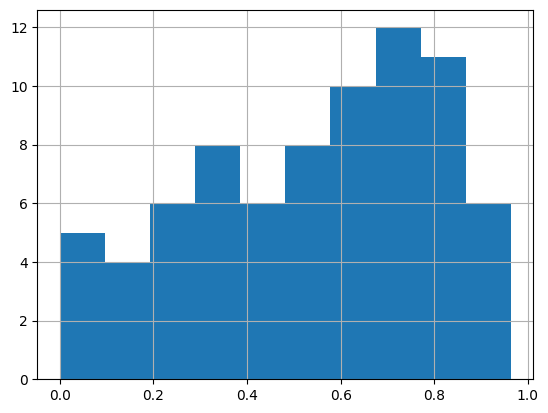

In [53]:
haplo_df_f_freq.drop_duplicates().groupby('Haploblock')['Max_AF'].mean().hist()#.mean()

In [54]:
hapl_stat_list = []
for hb in haplo_df_f_freq_dd.Haploblock.unique().tolist():
    hapl_df = haplo_df_f_freq_dd[haplo_df_f_freq_dd.Haploblock == hb]
    mean_freq = hapl_df.Max_AF.mean()
    length = hapl_df.sort_values(by='POS1').index[-1] - hapl_df.sort_values(by='POS1').index[0] 
    n_muts = hapl_df.shape[0]
    
    hapl_stat_list.append([hb, n_muts, length, mean_freq])

In [55]:
hapl_stat_df = pd.DataFrame(hapl_stat_list, columns=['Haploblock', 'N_muts', 'Length', 'Mean_freq'])
hapl_stat_df

,Haploblock,N_muts,Length,Mean_freq
0,1,26,91418,0.890220
1,23,64,15099,0.756572
2,45,13,3539,NaN
3,67,15,6897,NaN
4,89,24,20060,0.578969
...,...,...,...,...
115,2195,11,2964,0.546900
116,2196,11,1713,0.436582
117,2197,6,7046,0.233758
118,2198,9,5746,0.285593


In [67]:
hapl_stat_df.describe()

,Haploblock,N_muts,Length,Mean_freq
count,120.000000,120.000000,120.000000,76.000000
mean,1233.525000,13.358333,20645.866667,0.544117
std,703.463795,7.955544,85127.545829,0.262406
min,1.000000,4.000000,34.000000,0.000000
25%,618.750000,9.000000,2555.250000,0.343030
50%,1257.500000,11.000000,5785.500000,0.578935
75%,1854.250000,16.000000,9870.000000,0.757936
max,2199.000000,64.000000,664608.000000,0.963633


In [66]:
hapl_stat_df.sort_values(by='Length')

,Haploblock,N_muts,Length,Mean_freq
113,2193,7,34,0.343100
71,1458,11,89,0.275100
91,1982,6,119,NaN
69,1456,8,123,NaN
109,2189,6,165,NaN
...,...,...,...,...
35,750,10,76845,NaN
6,133,17,85175,0.848667
0,1,26,91418,0.890220
5,111,12,659145,0.424550


In [56]:
hapl_stat_df[hapl_stat_df['Length'] < 100000]['Length'].describe()

count      118.000000
mean      9777.550847
std      14921.624730
min         34.000000
25%       2543.750000
50%       5739.500000
75%       9776.500000
max      91418.000000
Name: Length, dtype: float64

<Axes: >

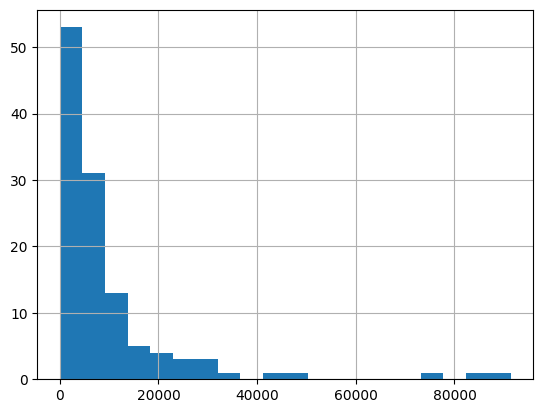

In [57]:
hapl_stat_df[hapl_stat_df['Length'] < 100000]['Length'].hist(bins=20)

In [58]:
hapl_stat_df['Mean_freq'].describe()

count    76.000000
mean      0.544117
std       0.262406
min       0.000000
25%       0.343030
50%       0.578935
75%       0.757936
max       0.963633
Name: Mean_freq, dtype: float64

In [59]:
hapl_stat_df[hapl_stat_df['Mean_freq'] < 0.01]

,Haploblock,N_muts,Length,Mean_freq
16,332,14,6129,0.0
37,815,15,29474,0.0


<Axes: xlabel='Length', ylabel='Mean_freq'>

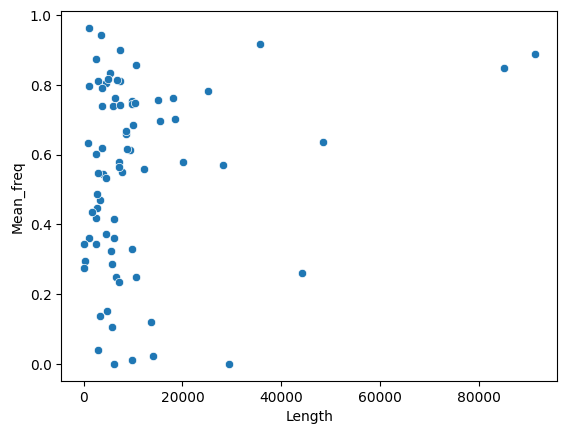

In [60]:
sns.scatterplot(data=hapl_stat_df[hapl_stat_df['Length'] < 100000], x='Length', y='Mean_freq')

In [61]:
hapl_stat_df_filtered = hapl_stat_df[(hapl_stat_df['Length'] > 10000) & (hapl_stat_df['Mean_freq'] < 0.01)]
hapl_stat_df_filtered

,Haploblock,N_muts,Length,Mean_freq
37,815,15,29474,0.0


In [62]:
haplo_df_f_freq_dd_filtered = haplo_df_f_freq_dd[haplo_df_f_freq_dd['Haploblock'].isin(hapl_stat_df_filtered['Haploblock'])]
haplo_df_f_freq_dd_filtered

,CHROM,REF1,ALT1,genotype,Haploblock,Haploblock_length,0,1,2,3,...,5,6,7,8,9,10,11,12,13,Max_AF
POS1,,,,,,,,,,,,,,,,,,,,,
21715040,chr15,G,A,11,815,21,chr15_21715040_G/A,chr15:21715040,A,ENSG00000281179,...,Transcript,downstream_gene_variant,-,-,-,-,-,rs1555378018,IMPACT=MODIFIER;DISTANCE=2768;STRAND=-1;FLAGS=...,0.0
21699813,chr15,A,G,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21729287,chr15,G,T,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21717447,chr15,C,CGCG,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21721460,chr15,A,T,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21706927,chr15,C,G,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21707350,chr15,G,A,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21706845,chr15,A,C,11,815,21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21711310,chr15,T,C,11,815,21,chr15_21711310_T/C,chr15:21711310,C,ENSG00000281087,...,Transcript,upstream_gene_variant,-,-,-,-,-,rs1555378003,IMPACT=MODIFIER;DISTANCE=1040;STRAND=-1,0.0


In [154]:
haplo_df_f_freq_dd_filtered.to_excel('Chinese_filtered_haploblocks.xlsx')

# Monte-Carlo

In [68]:
df_tmp = df_joined_chin.copy()

In [69]:
np.random.shuffle(df_tmp.genotype.tolist())

In [70]:
df_tmp.genotype

pos
chr10:100000235     BB
chr10:100001410     11
chr10:100001413     11
chr10:100002628     BB
chr10:100004077     BB
                  ... 
chr9:99997408       BB
chr9:99998283       BB
chr9:99999166       11
chr9:99999229      NaN
chr9:99999321       BB
Name: genotype, Length: 5493747, dtype: object

In [71]:
result = []
for _ in range(2):
    df_tmp.genotype = np.random.shuffle(df_tmp.genotype.tolist())
    haploblocks = calculate_haploblock_length(df_tmp)
    result.append(haploblocks)

In [72]:
def mote_carlo(df):
    
    result = []
    df_tmp = df.copy()
    for _ in range(200):
        l = df_tmp.genotype.tolist()
        np.random.shuffle(l)
        df_tmp.genotype = l
        haploblocks = calculate_haploblock_length(df_tmp)
        result.append(haploblocks)
        
    return result

In [ ]:
result = mote_carlo(df_joined_chin)

In [ ]:
longest_chain_list = []
for res in result:
    longest_chain = pd.Series(res).max()
    longest_chain_list.append(longest_chain)

In [ ]:
pd.Series(longest_chain_list).max()